## Import

In [1]:
import os 
import time 
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import torch
from torch import nn, optim
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as utils
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np


## Data handling (loading+transforming+augumentation)

In [2]:
class LipsSet2(Dataset):
    def __init__(self, parent_dir, image_dir, mask_dir):

        self.mask_list = glob.glob(parent_dir+'/'+mask_dir+'/*')
        self.mask_list.sort()
        self.image_list = []

        # an image exists for every mask
        for path in self.mask_list:
            self.image_list.append(path.replace(mask_dir, image_dir))
        self.mask_list = self.mask_list
                
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):

        img_path = self.image_list[idx]
        mask_path = self.mask_list[idx]
        
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        
        img = cv2.cvtColor(cv2.resize(img, (256, 256)), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.resize(mask, (256, 256)), cv2.COLOR_RGBA2GRAY)
        mask = mask.reshape((256, 256, 1))  # Zmiana kształtu na (256, 256, 1)

        img = img.astype(float)
        img = torch.as_tensor(img, dtype=torch.float) / 255.0
        img = img.permute(2, 0, 1)  # Permutujemy do formatu (C, H, W)

        cls_mask_1 = np.where(mask[..., 0] > 50, 1, 0).astype('float')

        mask = torch.as_tensor([cls_mask_1], dtype=torch.float)  

        return img, mask

In [3]:
dataset = LipsSet2('.', 'images', 'proper_masks')

In [5]:
def train_val_test_split(dataset):
    train_dataset = torch.utils.data.Subset(dataset, range(0, int(0.8 * len(dataset))))
    val_dataset = torch.utils.data.Subset(dataset, range(int(0.8*len(dataset)), int(0.9*len(dataset))))
    test_dataset = torch.utils.data.Subset(dataset, range(int(0.9*len(dataset)), len(dataset)))
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = train_val_test_split(dataset)


In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

C:\Users\aleks\AppData\Local\Temp\ipykernel_45892\723420462.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  mask = torch.as_tensor([cls_mask_1], dtype=torch.float)


torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])
tensor(0.) tensor(1.)


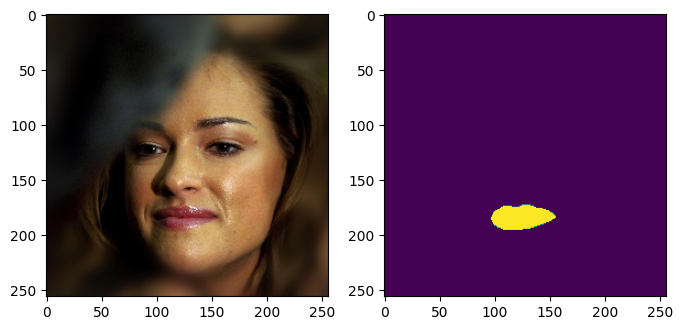

In [7]:
for imgs, masks in train_loader:
    print(imgs.shape)
    print(masks.shape)
    print(masks.min(), masks.max())
    fig, ax = plt.subplots(1, 2, figsize=(8, 8))
    ax[0].imshow(imgs[0].permute(1, 2, 0))
    ax[1].imshow(masks[0].permute(1, 2, 0))
    break

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

## Model

In [9]:
import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp

class SegmentationModel:
    def __init__(self, model_path, backbone='vgg19', lr=0.001, num_epochs=15, device='cpu'):
        self.model_path = model_path
        self.device = device
        self.model = smp.Unet(encoder_name=backbone, classes=1, activation='sigmoid').to(self.device)
        self.criterion = utils.losses.DiceLoss()
        self.metrics = [utils.metrics.IoU(), utils.metrics.Recall(), utils.metrics.Accuracy()]
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        self.train_epoch = utils.train.TrainEpoch(
            self.model, 
            loss=self.criterion, 
            metrics=self.metrics,
            optimizer=self.optimizer,
            device=self.device,
            verbose=True
        )

        self.valid_epoch = utils.train.ValidEpoch(
            self.model, 
            loss=self.criterion, 
            metrics=self.metrics,
            device=self.device,
            verbose=True
        )

        self.num_epochs = num_epochs
        self.max_score = 0

        self.train_losses_dice= []
        self.val_losses_dice = []
        self.train_losses_iou= []
        self.val_losses_iou = []

    def train(self, train_loader, valid_loader):
        for i in range(self.num_epochs):
            print(f'Epoch: {i + 1}')
            train_logs = self.train_epoch.run(train_loader)
            valid_logs = self.valid_epoch.run(valid_loader)

            self.train_losses_dice.append(train_logs['dice_loss'])
            self.val_losses_dice.append(valid_logs['dice_loss'])
            self.train_losses_iou.append(train_logs['iou_score'])
            self.val_losses_iou.append(valid_logs['iou_score'])

            if self.max_score < valid_logs['iou_score']:
                self.max_score = valid_logs['iou_score']
                torch.save(self.model.state_dict(), self.model_path)
                print('Model weights saved!')


        self.plot_losses_dice()
        self.plot_losses_iou()


    def get_test_score(self, test_loader):
        test_epoch = smp.utils.train.ValidEpoch(
        self.model,
        loss=self.criterion, 
        metrics=self.metrics, 
        device=self.device,
        verbose=True,
        )

        test_logs = test_epoch.run(test_loader)
        print("Evaluation on Test Data: ")
        print(f"Mean IoU Score: {test_logs['iou_score']:.4f}")
        print(f"Mean Recall Loss: {test_logs['recall']:.4f}")
        print(f"Mean Accuracy: {test_logs['accuracy']:.4f}")

    def plot_losses_dice(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, self.num_epochs + 1), self.train_losses_dice, label='Train Loss')
        plt.plot(range(1, self.num_epochs + 1), self.val_losses_dice, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss per Epoch- Dice')
        plt.legend()
        plt.show()

    def plot_losses_iou(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, self.num_epochs + 1), self.train_losses_iou, label='Train Loss')
        plt.plot(range(1, self.num_epochs + 1), self.val_losses_iou, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss per Epoch - IOU')
        plt.legend()
        plt.show()


Epoch: 1
valid: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it, dice_loss - 0.1553, iou_score - 0.7701, recall - 0.933, accuracy - 0.9966] 
Model weights saved!
Epoch: 2
valid: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it, dice_loss - 0.09664, iou_score - 0.8336, recall - 0.8931, accuracy - 0.9978]
Model weights saved!
Epoch: 3
valid: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it, dice_loss - 0.09016, iou_score - 0.8402, recall - 0.9254, accuracy - 0.9978]
Model weights saved!
Epoch: 4
valid: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, dice_loss - 0.08756, iou_score - 0.8439, recall - 0.908, accuracy - 0.9979] 
Model weights saved!
Epoch: 5
valid: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it, dice_loss - 0.09679, iou_score - 0.8274, recall - 0.895, accuracy - 0.9977] 
Epoch: 6
valid: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it, dice_loss - 0.08019, iou_score - 0.8541, recall - 0.9052, accuracy - 0.9981]
Model weights saved!
Epoch: 7
valid: 100%|██████████| 25/25 [00:31<00:0

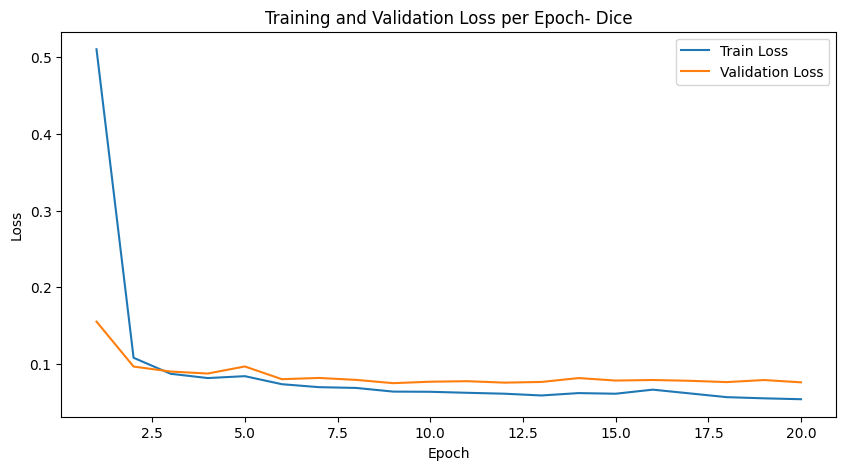

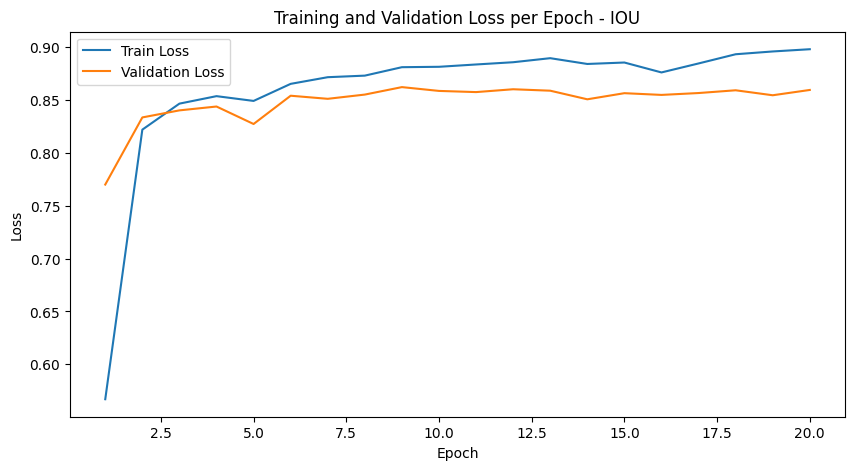

In [10]:
trainer = SegmentationModel(model_path='vgg_models/model_20_epoch_1712.pth', num_epochs=20)
trainer.train(train_loader, valid_loader)

In [27]:
trainer.get_test_score(test_loader)

valid: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it, dice_loss - 0.07611, iou_score - 0.8596, recall - 0.915, accuracy - 0.9982] 
Evaluation on Test Data: 
Mean IoU Score: 0.8596
Mean Recall Loss: 0.9150
Mean Accuracy: 0.9982


In [12]:
data_iter = iter(test_loader)

images, labels = next(data_iter)

images, labels = images.to(device), labels.to(device)

outputs = trainer.model(images)

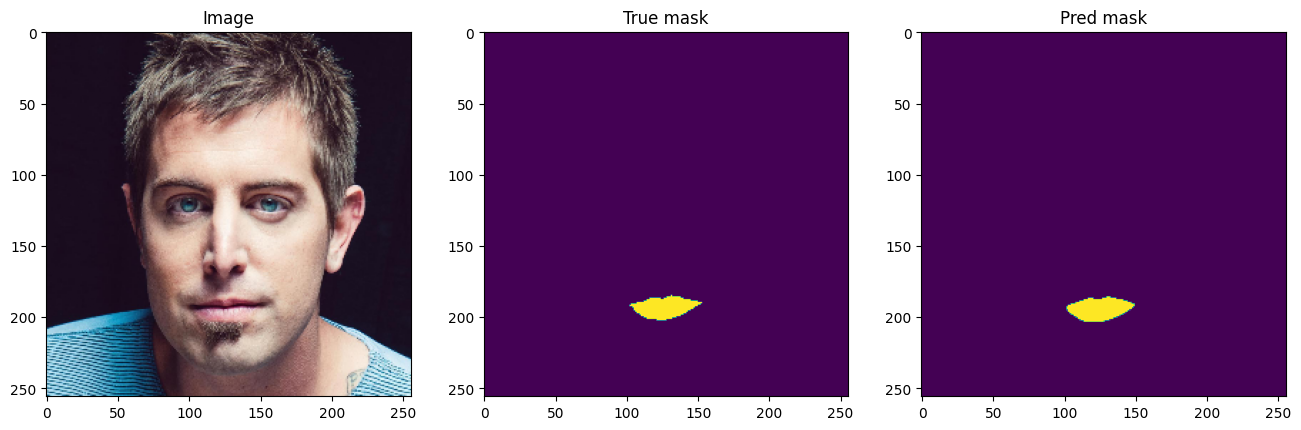

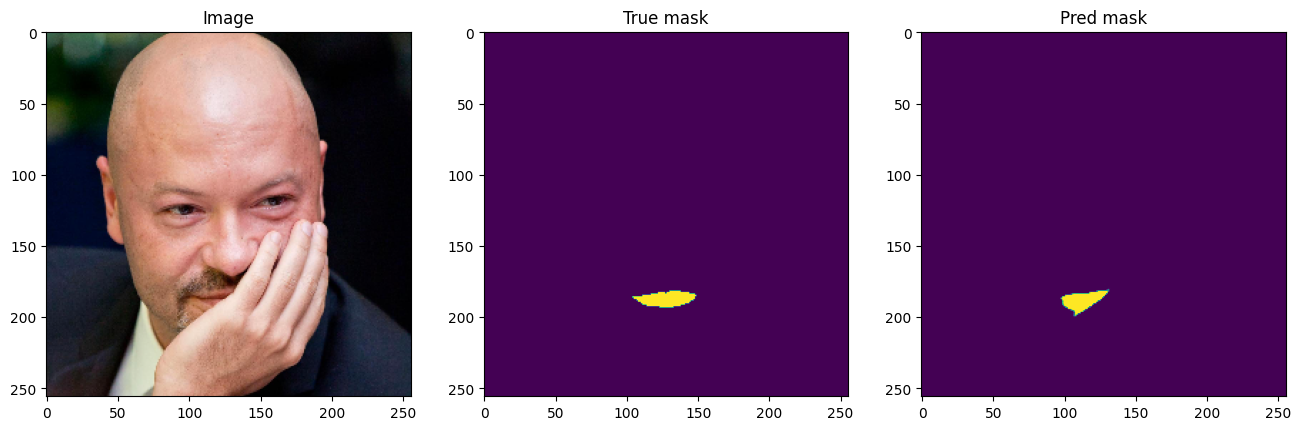

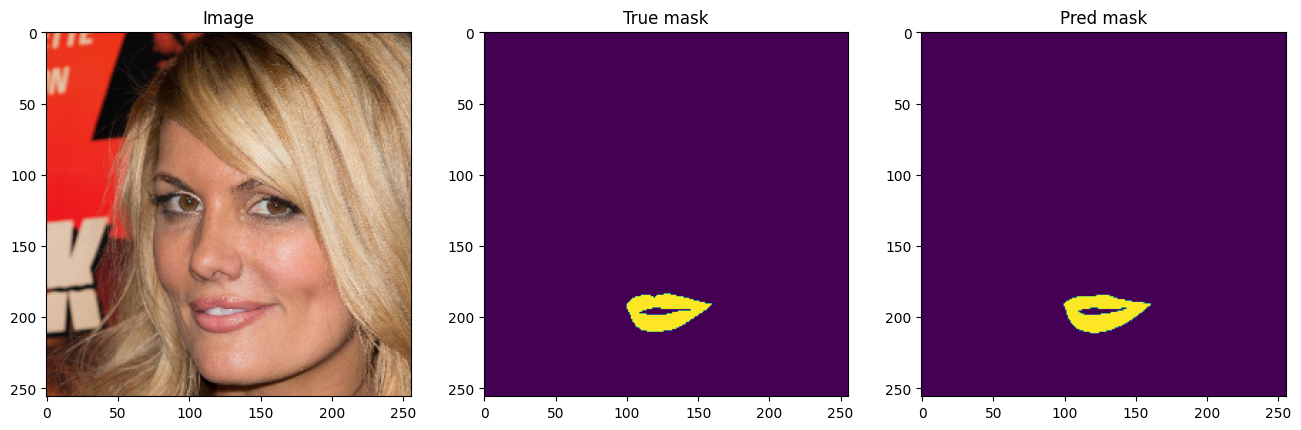

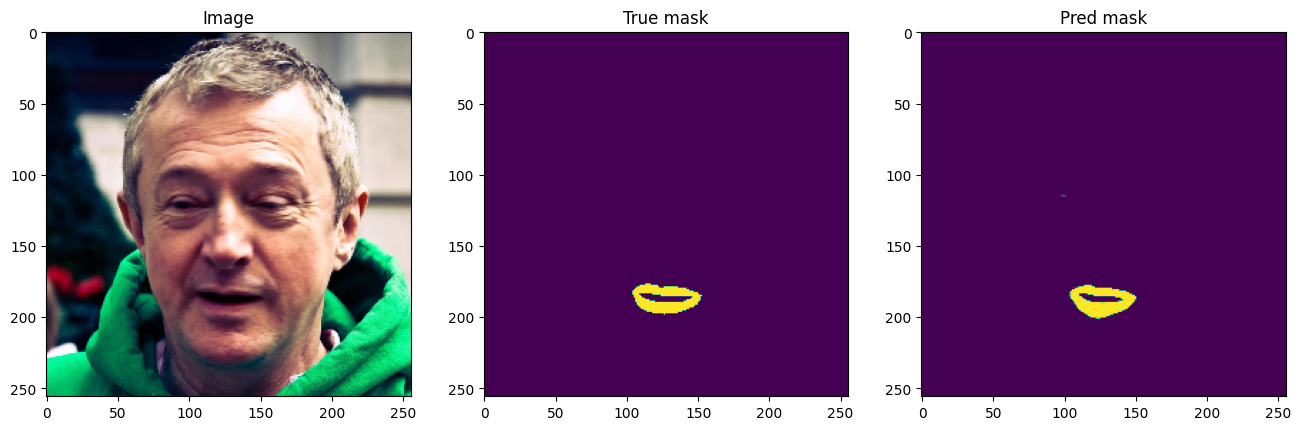

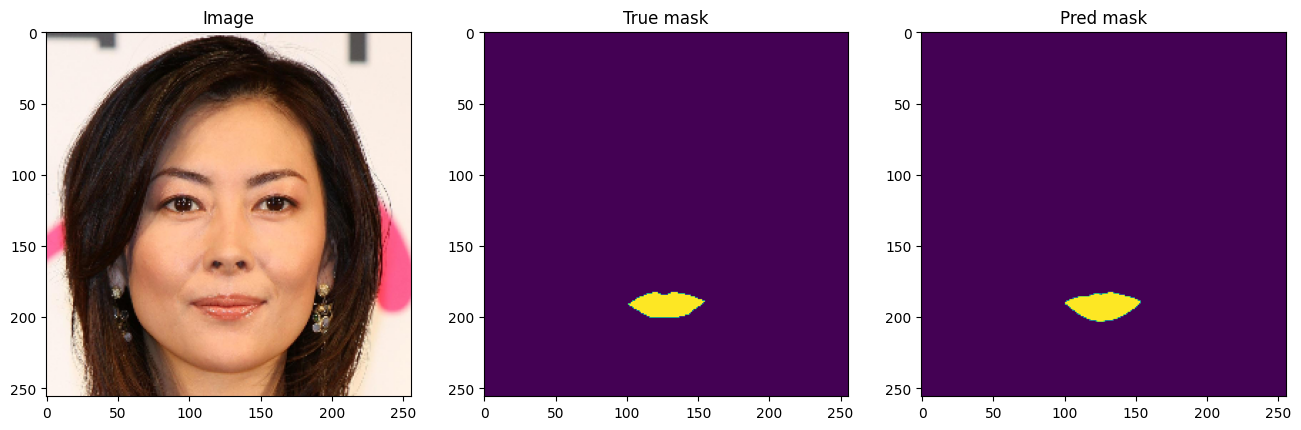

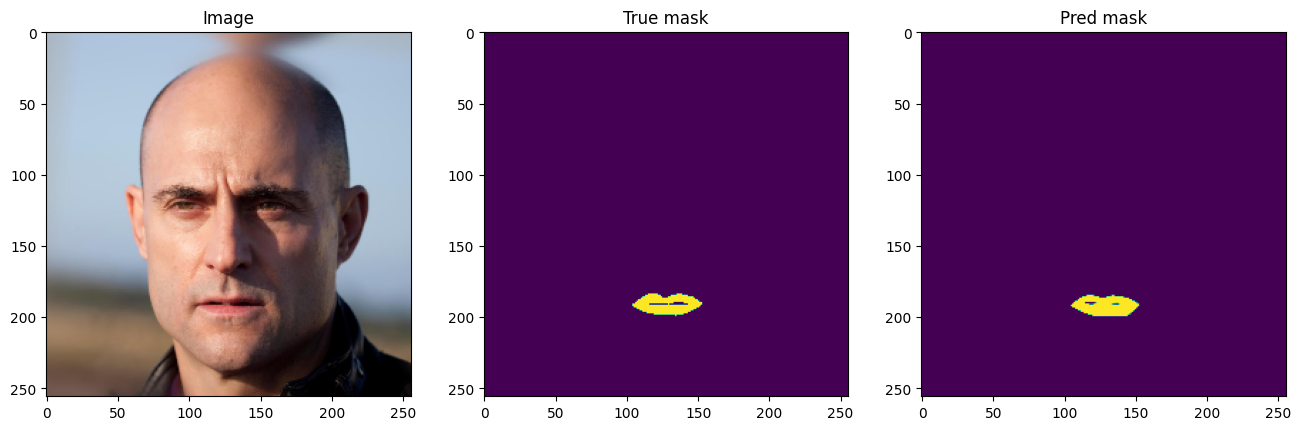

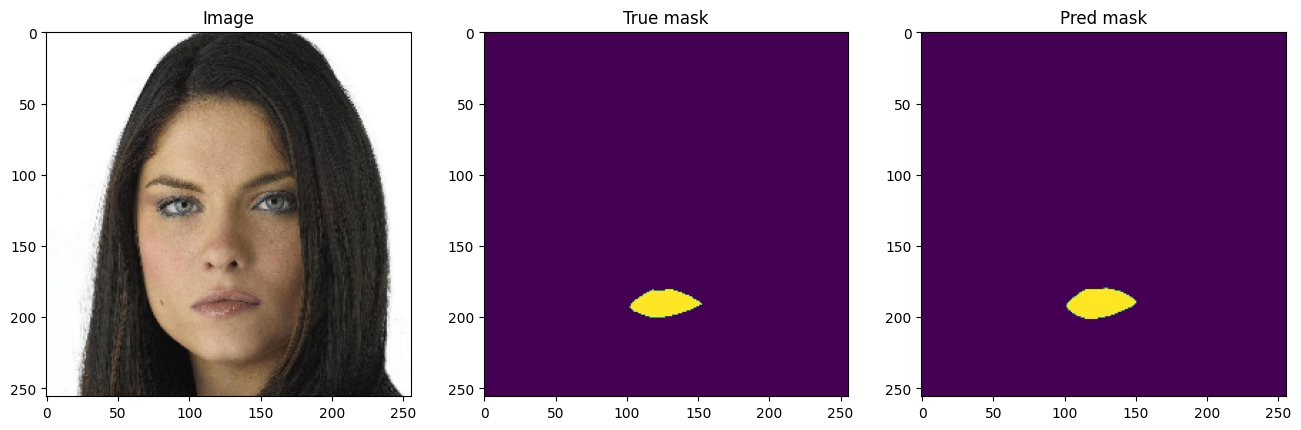

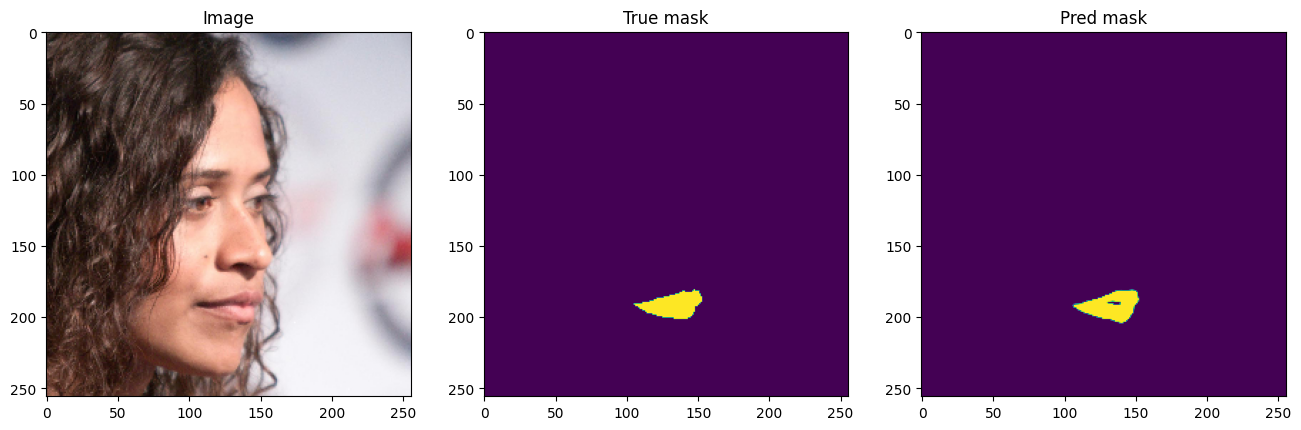

In [13]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
    ax_2.set_title('True mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
    ax_3.set_title('Pred mask')

## Wyświetlanie pojedynczego zdjęcia 

In [14]:
def preprocess_img(image_path, new_size = (256,256)):
    image = cv2.imread(image_path)
    img = cv2.cvtColor(cv2.resize(image, new_size), cv2.COLOR_BGR2RGB)
        
    img = img.astype(float)
    img = torch.as_tensor(img, dtype=torch.float) / 255.0
    img = img.permute(2, 0, 1)  # Permutujemy do formatu (C, H, W)
    return img

In [66]:
def get_pred(img_path, model_path, device='cpu'):
    model = smp.Unet(encoder_name='vgg19', classes=1, activation='sigmoid').to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Przejdź w tryb predykcji

    image = preprocess_img(img_path)
    image = image.unsqueeze(0).float().to(device)

    with torch.no_grad():
        output = model(image)

    output_image = output.squeeze(0).cpu().numpy() 
    output_image = (output_image > 0.5).astype(np.uint8)  
    output_image = np.transpose(output_image, (1, 2, 0))  

    return output_image


In [67]:
def get_mask_on_photo(img, pred):
    mask = np.zeros_like(img)
    mask[:, :, 0] = pred[:, :, 0] * 255  # bierzemy czerwony jako usta
    alpha = 0.2
    masked_image = cv2.addWeighted(img, 1 - alpha, mask, alpha, 0)
    return masked_image

In [69]:
def print_prediction(path_img, model_path):
    img = cv2.imread(path_img)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = get_pred(path_img, model_path)
    masked_image = get_mask_on_photo(img, mask)

    fig = plt.figure(figsize = (16,5))
    a = fig.add_subplot(1, 3, 1)
    imgplot = plt.imshow(img)
    a.set_title('Input')
    a = fig.add_subplot(1, 3, 2)
    imgplot = plt.imshow(mask)
    a.set_title('Output')
    a = fig.add_subplot(1, 3, 3)
    imgplot = plt.imshow(masked_image)


In [70]:
model_path2 = r'C:\Users\aleks\OneDrive\Documents\LIPS SEGMENTATION\vgg_models\model_20_epoch_1712.pth'

C:\Users\aleks\AppData\Local\Temp\ipykernel_45892\269656751.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

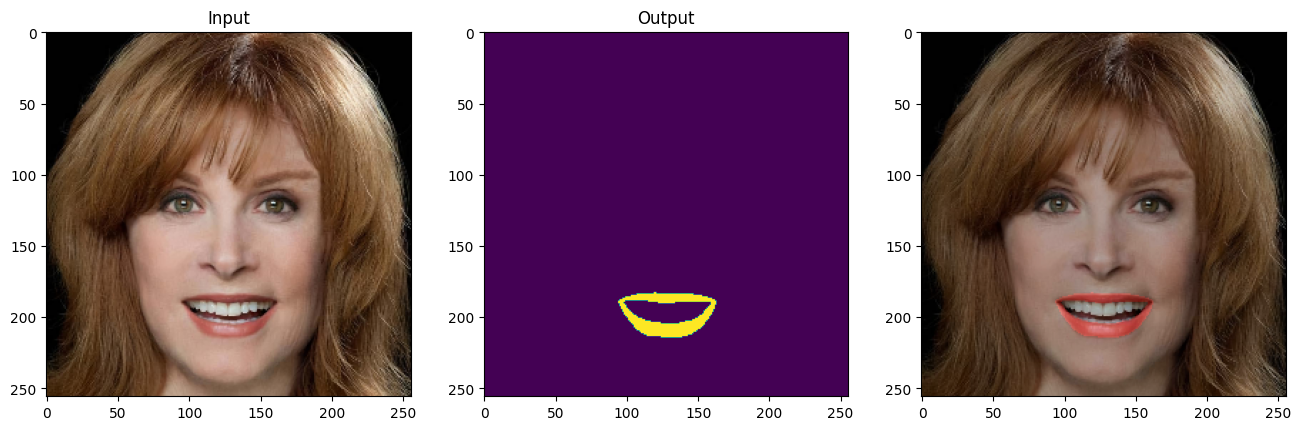

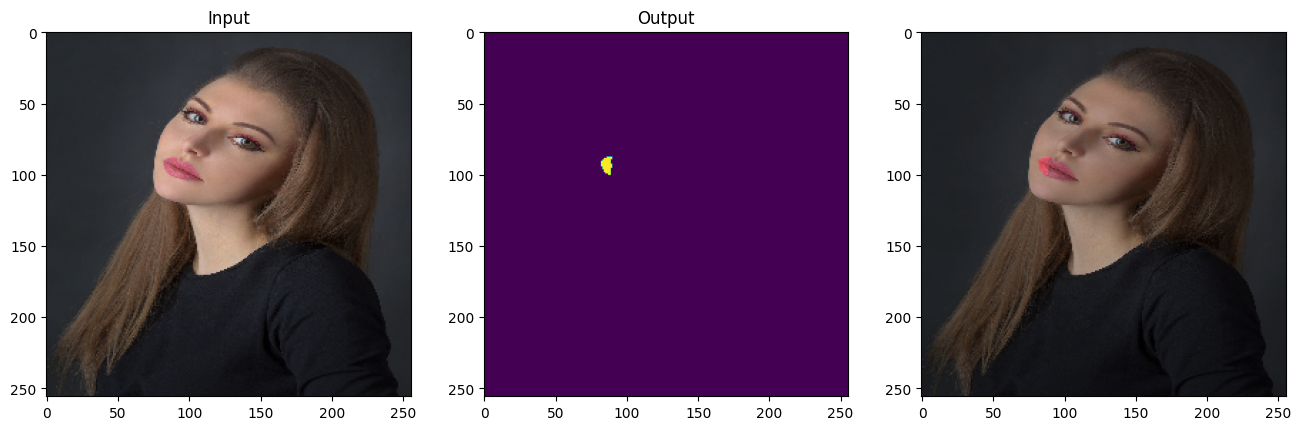

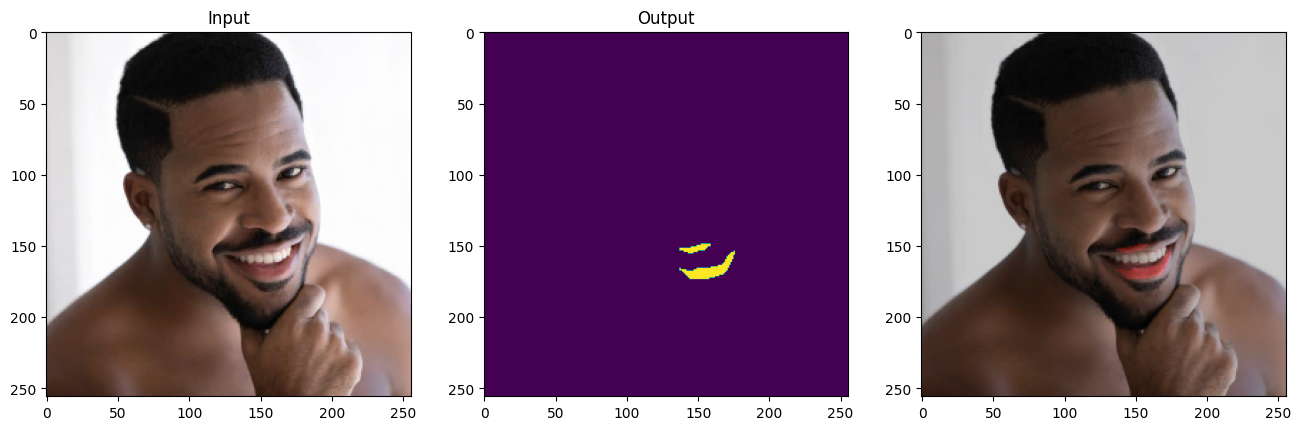

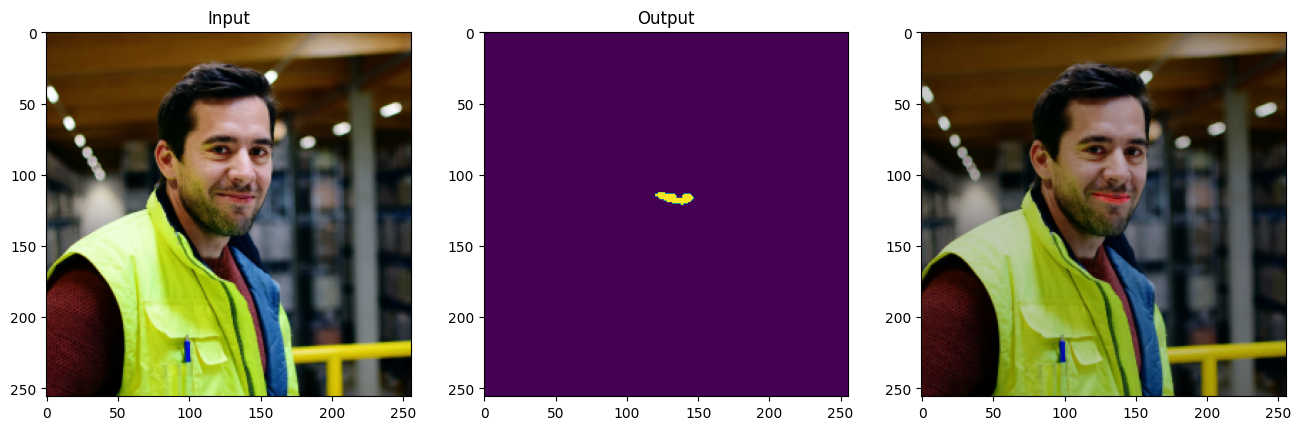

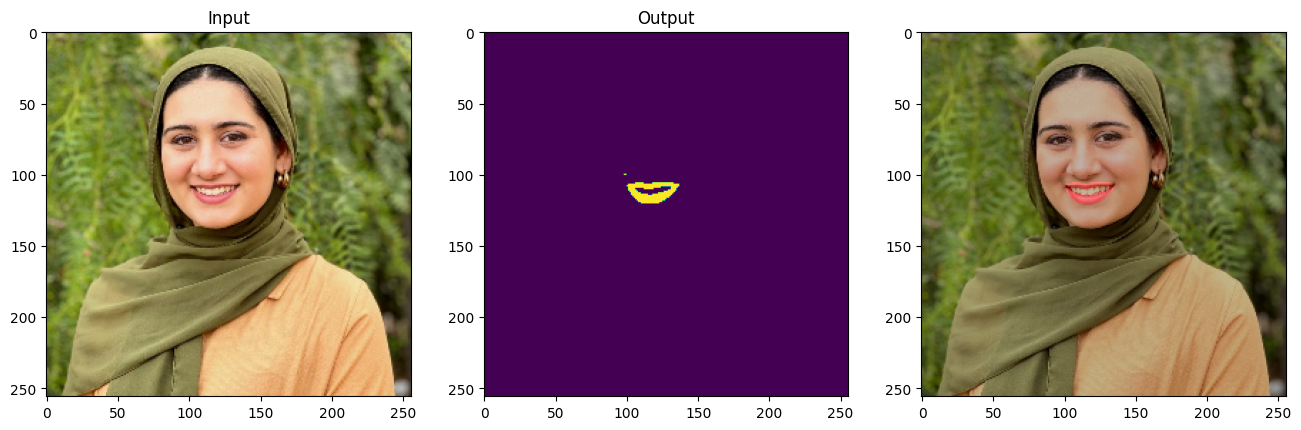

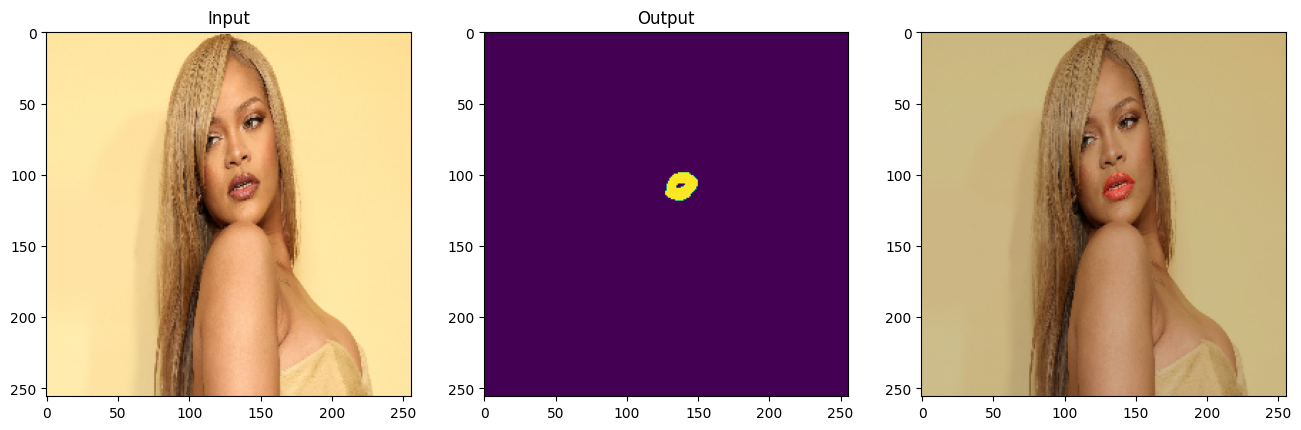

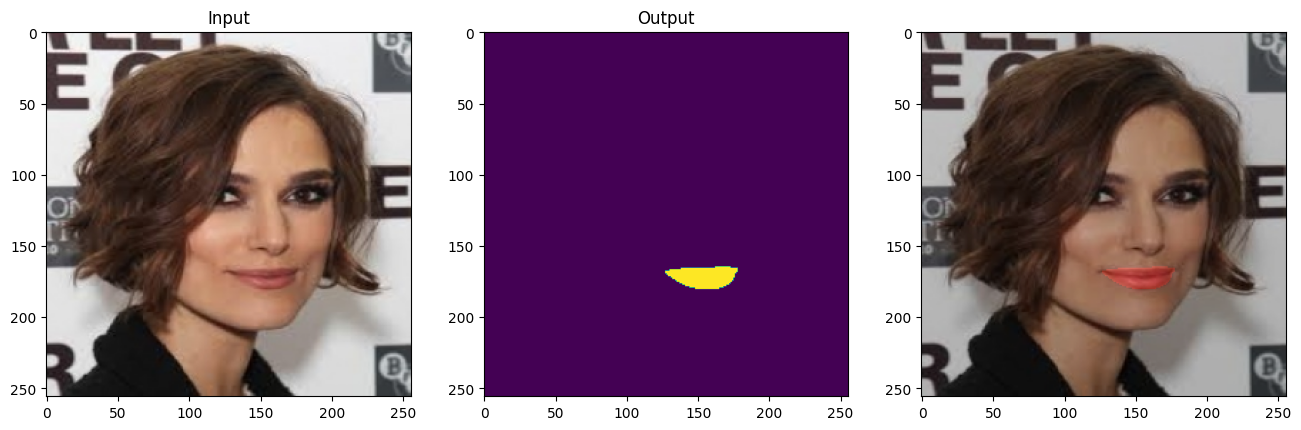

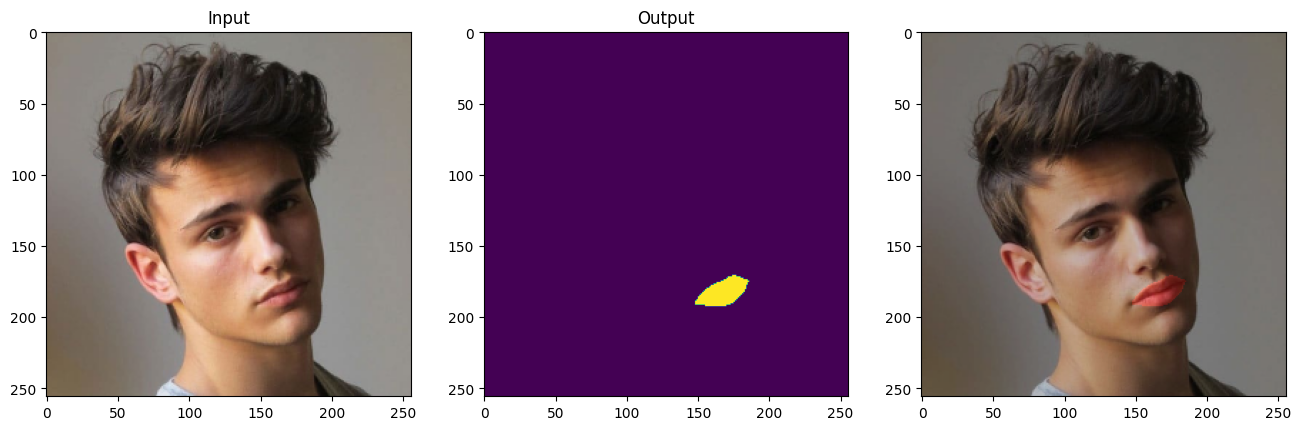

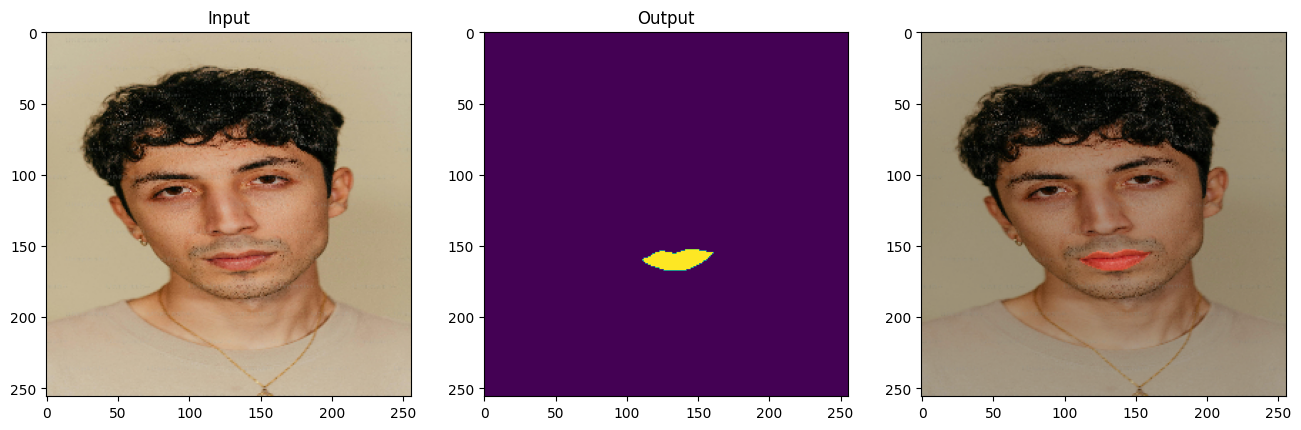

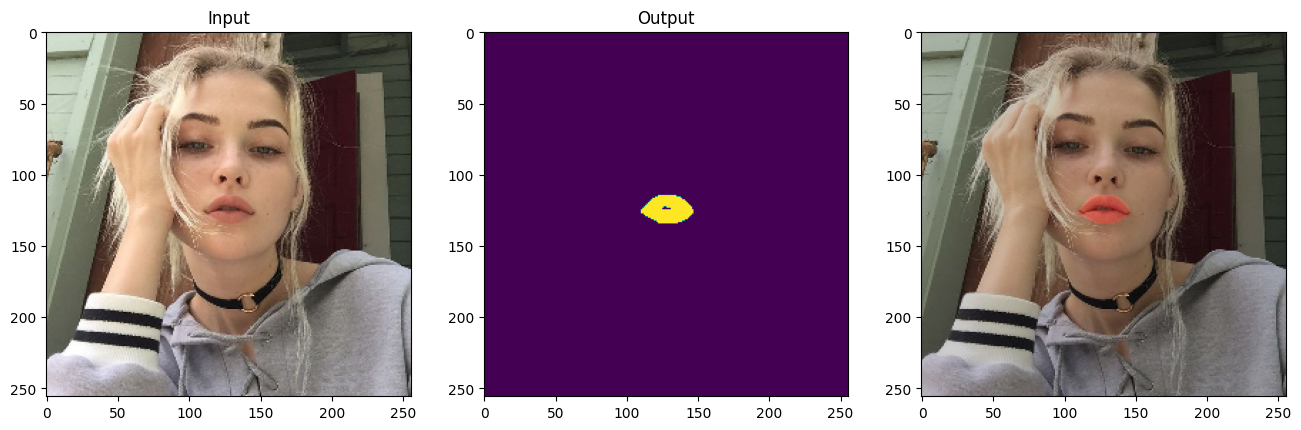

In [71]:
for i in range(10):
    print_prediction(f'C:\\Users\\aleks\\OneDrive\\Documents\\LIPS SEGMENTATION\\test_img\\test{i}.jpg', model_path2)

C:\Users\aleks\AppData\Local\Temp\ipykernel_45892\269656751.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

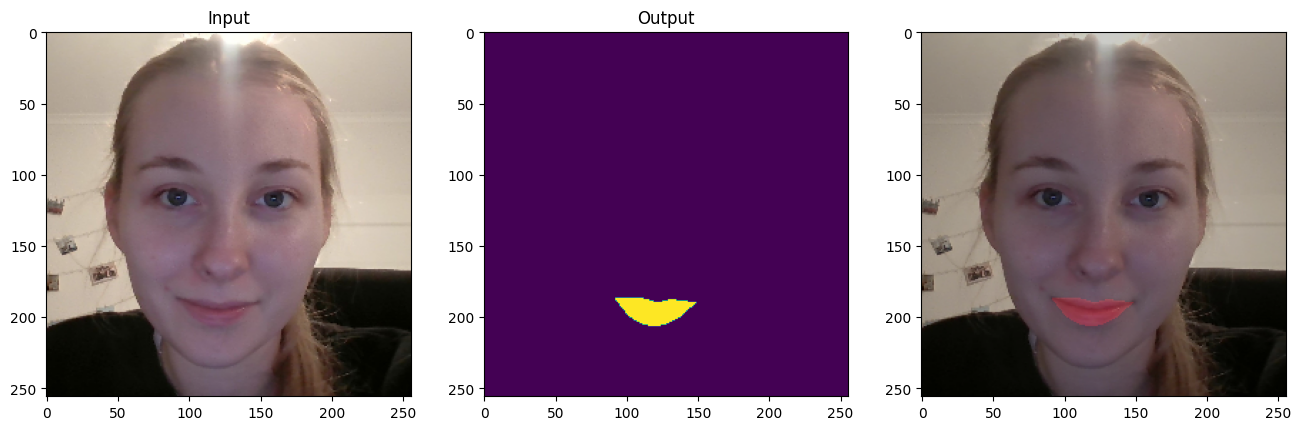

In [72]:
print_prediction(r'C:\Users\aleks\OneDrive\Pictures\Camera Roll\WIN_20241030_16_48_01_Pro.jpg', model_path2)

C:\Users\aleks\AppData\Local\Temp\ipykernel_45892\269656751.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

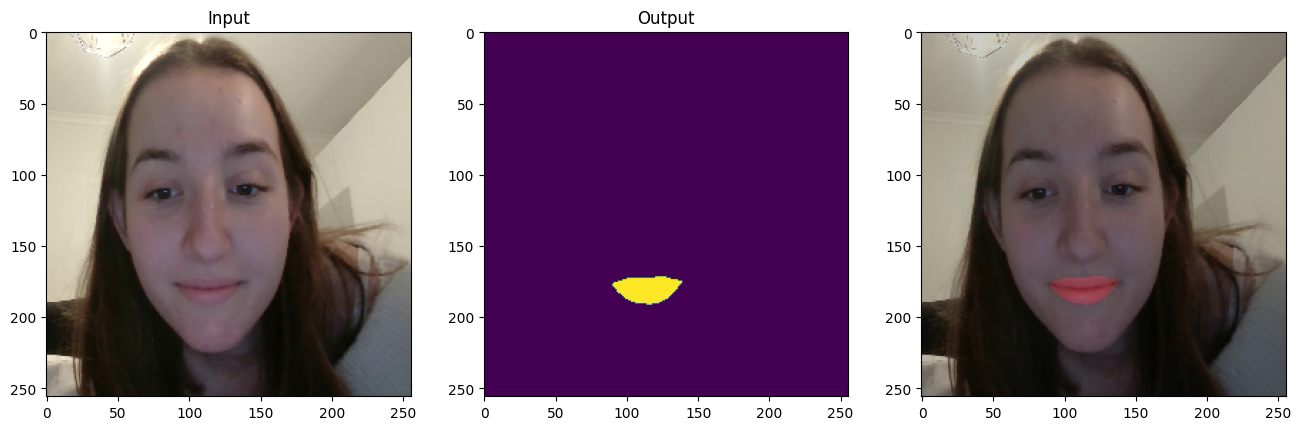

In [73]:
print_prediction(r'C:\Users\aleks\OneDrive\Pictures\Camera Roll\Zrzut ekranu 2024-11-02 182839.png', model_path2)

In [74]:

def capture_mask_from_camera(model_path):
    camera = cv2.VideoCapture(0)

    desired_size = 256
    while True:
        ret,frame = camera.read()
        # Pobranie wymiarów obrazu
        height, width = frame.shape[:2]

        # Obliczenie współrzędnych ramki 256x256 na środku obrazu
        x_start = (width - desired_size) // 2
        y_start = (height - desired_size) // 2
        x_end = x_start + desired_size
        y_end = y_start + desired_size

        # Narysowanie ramki na podglądzie
        cv2.rectangle(frame, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)

        cv2.imshow("Podgląd z kamery", frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('s'):
            cropped_frame = frame[y_start:y_end, x_start:x_end]
            cv2.imwrite('zdjecie.png', cropped_frame)
            print('Zdjecie zapisane')
        elif key == ord('q'):
            break

    camera.release()
    cv2.destroyAllWindows()

    print_prediction(r'zdjecie.png', model_path)


Zdjecie zapisane


C:\Users\aleks\AppData\Local\Temp\ipykernel_45892\269656751.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

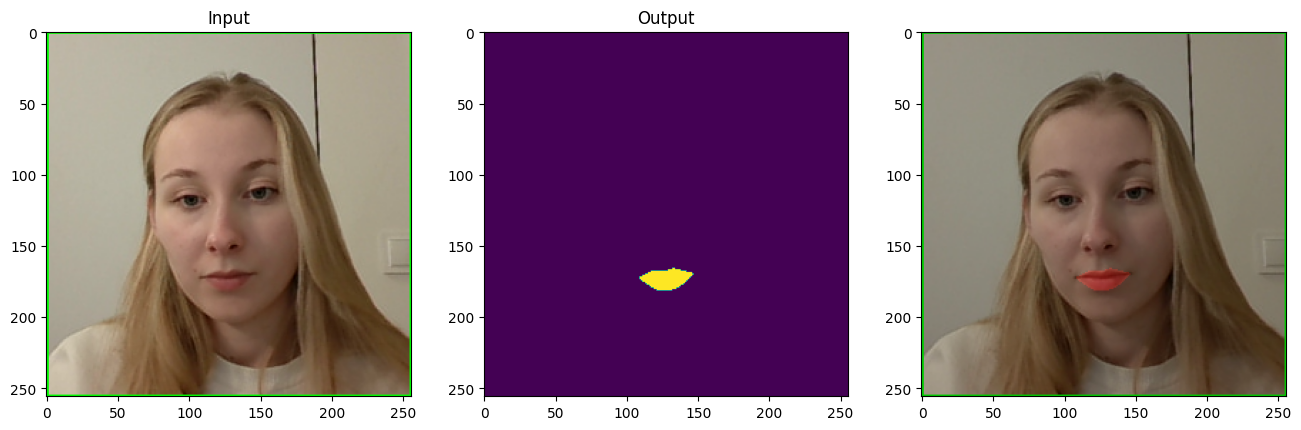

In [75]:
capture_mask_from_camera(model_path2)